# Train the GP emulator for the JIMWLK dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter

from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
from src.emulator import Emulator

In [8]:
def rms_abs_prediction_err(emu_pred,vali_true):
    rms_abs_pred_err = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / vali_true[testpoint,obsIdx])**2.
        rms_abs_pred_err[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_abs_pred_err

def how_honest_is_GP(emu_pred,emu_pred_err,vali_true):
    rms_quantity = np.zeros(emu_pred.shape[1])
    for obsIdx in range(emu_pred.shape[1]):
        quantity = np.zeros(emu_pred.shape[1])
        for testpoint in range(emu_pred.shape[0]):
            quantity[obsIdx] += ((emu_pred[testpoint,obsIdx] - vali_true[testpoint,obsIdx]) / emu_pred_err[testpoint,obsIdx])**2.
        rms_quantity[obsIdx] = np.sqrt(quantity[obsIdx] / emu_pred.shape[0])
    return rms_quantity

def train_multiple_emulators(training_set, model_par, number_test_points):
    emu1 = EmulatorBAND(training_set, model_par, method='PCSK', logTrafo=False, parameterTrafoPCA=False)
    emu2 = Emulator(training_set, model_par, npc = 4, logTrafo=False, parameterTrafoPCA=False)

    output_emu1 = emu1.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_1 = output_emu1[0]
    emu_pred_err_1 = output_emu1[1]
    vali_data_1 = output_emu1[2]
    vali_data_err_1 = output_emu1[3]

    output_emu2 = emu2.testEmulatorErrors(nTestPoints=number_test_points)
    emu_pred_2 = output_emu2[0]
    emu_pred_err_2 = output_emu2[1]
    vali_data_2 = output_emu2[2]
    vali_data_err_2 = output_emu2[3]

    nObs = vali_data_1.shape[1]  # Assuming all datasets have the same number of observables

    rms_abs_pred_err1 = rms_abs_prediction_err(emu_pred_1,vali_data_1)
    rms_abs_pred_err2 = rms_abs_prediction_err(emu_pred_2,vali_data_2)
    honesty_1 = how_honest_is_GP(emu_pred_1,emu_pred_err_1,vali_data_1)
    honesty_2 = how_honest_is_GP(emu_pred_2,emu_pred_err_2,vali_data_2)
    
    return (rms_abs_pred_err1,rms_abs_pred_err2), (honesty_1,honesty_2)

def train_multiple_emulators_BAND(training_set, model_par, number_test_points, max_rel_err):
    emu1 = EmulatorBAND(training_set, model_par, method='PCSK', logTrafo=True, parameterTrafoPCA=False, max_rel_uncertainty_data=max_rel_err)

    output_emu1 = emu1.testEmulatorErrors(number_test_points=number_test_points)
    emu_pred_1 = output_emu1[0]
    emu_pred_err_1 = output_emu1[1]
    vali_data_1 = output_emu1[2]
    vali_data_err_1 = output_emu1[3]

    nObs = vali_data_1.shape[1]  # Assuming all datasets have the same number of observables

    rms_abs_pred_err1 = rms_abs_prediction_err(emu_pred_1,vali_data_1)
    honesty_1 = how_honest_is_GP(emu_pred_1,emu_pred_err_1,vali_data_1)
    
    return (rms_abs_pred_err1), (honesty_1)

def write_output_to_csv_uncertainties(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in data:
            writer.writerow([row])

def train_multiple_emulators_and_write_to_csv(training_set, model_par, number_test_points, output_file):
    (rms_abs_pred_err1, rms_abs_pred_err2), (honesty_1, honesty_2) = train_multiple_emulators(training_set, model_par, number_test_points)

    # Write rms_abs_pred_err1, rms_abs_pred_err2 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_pred_err_obs_1.dat', rms_abs_pred_err1)
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_pred_err_obs_2.dat', rms_abs_pred_err2)

    # Write honesty_1, honesty_2 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_GP_honesty_obs_1.dat', honesty_1)
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_GP_honesty_obs_2.dat', honesty_2)

def train_multiple_emulators_and_write_to_csv_BAND(training_set, model_par, number_test_points, max_rel_err, output_file):
    (rms_abs_pred_err1), (honesty_1) = train_multiple_emulators_BAND(training_set, model_par, number_test_points, max_rel_err)

    # Write rms_abs_pred_err1 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_pred_err_obs_1.dat', rms_abs_pred_err1)

    # Write honesty_1 to CSV
    write_output_to_csv_uncertainties(output_file + f'_{number_test_points}_GP_honesty_obs_1.dat', honesty_1)

def read_emulator_file_errors(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            data.append(float(line.strip()))
    return data

def read_multiple_emulator_errors_files(number_test_points_list,foldername,filename):
    data_list1 = []
    data_list2 = []
    for i in number_test_points_list:
        filename1 = f"./{foldername}/{filename}_{i}_pred_err_obs_1.dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

        filename2 = f"./{foldername}/{filename}_{i}_pred_err_obs_2.dat"
        data2 = read_emulator_file_errors(filename2)
        data_list2.append(data2)
    
    data_list4 = []
    data_list5 = []
    for i in number_test_points_list:
        filename4 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_1.dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

        filename5 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_2.dat"
        data5 = read_emulator_file_errors(filename5)
        data_list5.append(data5)

    return (data_list1,data_list2), (data_list4,data_list5)

def read_multiple_emulator_errors_files_BAND(number_test_points_list,foldername,filename):
    data_list1 = []
    for i in number_test_points_list:
        filename1 = f"./{foldername}/{filename}_{i}_pred_err_obs_1.dat"
        data1 = read_emulator_file_errors(filename1)
        data_list1.append(data1)

    data_list4 = []
    for i in number_test_points_list:
        filename4 = f"./{foldername}/{filename}_{i}_GP_honesty_obs_1.dat"
        data4 = read_emulator_file_errors(filename4)
        data_list4.append(data4)

    return (data_list1), (data_list4)


In [ ]:
model_par = "./IP_DIFF_JIMWLK_prior_range_delete_unused"
path_output = "./emulator_test_output/"
data_path = "./training_data_JIMWLK.pkl"
if not os.path.exists(path_output):
    os.makedirs(path_output)

for i in [500,400,300,200,100]:
    train_multiple_emulators_and_write_to_csv(data_path, model_par, i, path_output + 'JIMWLK')

In [9]:
model_par = "./IP_DIFF_JIMWLK_prior_range_delete_unused"
path_output = "./emulator_test_output_separate_emu/"
data_path = ["./training_data_JIMWLK_set1.pkl",
             "./training_data_JIMWLK_set2.pkl",
             "./training_data_JIMWLK_set3.pkl"]
if not os.path.exists(path_output):
    os.makedirs(path_output)

#for i in [500,400,300,200,100]:
#    k = 1
#    for path in data_path:
#        train_multiple_emulators_and_write_to_csv(path, model_par, i, path_output + f'JIMWLK_set{k}')
#        k += 1

for i in [200,100,50]:
    train_multiple_emulators_and_write_to_csv_BAND(data_path[0], model_par, i, 0.1, path_output + 'JIMWLK_set1')

[INFO][emulator_BAND] loading training data from ./training_data_JIMWLK_set1.pkl ...
[INFO][emulator_BAND] Discard Parameter 580, stat err = 1.48
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 596, discarded points: 1
[INFO][emulator_BAND] Validation GP emulator ...
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 396 training points ...
[INFO][emulator_BAND] loading training data from ./training_data_JIMWLK_set1.pkl ...
[INFO][emulator_BAND] Discard Parameter 580, stat err = 1.48
[INFO][emulator_BAND] All training data are loaded.
[INFO][emulator_BAND] Training dataset size: 596, discarded points: 1
[INFO][emulator_BAND] Validation GP emulator ...
[INFO][emulator_BAND] Performing emulator training ...
[INFO][emulator_BAND] Train GP emulators with 496 training points ...
[INFO][emulator_BAND] loading training data from ./training_data_JIMWLK_set1.pkl ...
[INFO][emulator_BAND] Discard P

In [10]:
for i in [200,100,50]:
    train_multiple_emulators_and_write_to_csv_BAND(data_path[1], model_par, i, 0.1, path_output + 'JIMWLK_set2')

[INFO][emulator_BAND] loading training data from ./training_data_JIMWLK_set2.pkl ...
[INFO][emulator_BAND] Discard Parameter 001, stat err = 0.10
[INFO][emulator_BAND] Discard Parameter 010, stat err = 0.11
[INFO][emulator_BAND] Discard Parameter 012, stat err = 0.12
[INFO][emulator_BAND] Discard Parameter 014, stat err = 0.20
[INFO][emulator_BAND] Discard Parameter 019, stat err = 0.13
[INFO][emulator_BAND] Discard Parameter 025, stat err = 0.12
[INFO][emulator_BAND] Discard Parameter 030, stat err = 0.23
[INFO][emulator_BAND] Discard Parameter 035, stat err = 0.20
[INFO][emulator_BAND] Discard Parameter 036, stat err = 0.11
[INFO][emulator_BAND] Discard Parameter 037, stat err = 0.10
[INFO][emulator_BAND] Discard Parameter 039, stat err = 0.13
[INFO][emulator_BAND] Discard Parameter 045, stat err = 0.11
[INFO][emulator_BAND] Discard Parameter 048, stat err = 0.11
[INFO][emulator_BAND] Discard Parameter 050, stat err = 0.12
[INFO][emulator_BAND] Discard Parameter 051, stat err = 0.11


In [11]:
for i in [200,100,50]:
    train_multiple_emulators_and_write_to_csv_BAND(data_path[2], model_par, i, 0.25, path_output + 'JIMWLK_set3')

[INFO][emulator_BAND] loading training data from ./training_data_JIMWLK_set3.pkl ...
[INFO][emulator_BAND] Discard Parameter 000, stat err = 0.89
[INFO][emulator_BAND] Discard Parameter 001, stat err = 0.39
[INFO][emulator_BAND] Discard Parameter 006, stat err = 0.33
[INFO][emulator_BAND] Discard Parameter 007, stat err = 0.36
[INFO][emulator_BAND] Discard Parameter 008, stat err = 1.02
[INFO][emulator_BAND] Discard Parameter 012, stat err = 0.28
[INFO][emulator_BAND] Discard Parameter 014, stat err = 0.51
[INFO][emulator_BAND] Discard Parameter 015, stat err = 0.41
[INFO][emulator_BAND] Discard Parameter 016, stat err = 0.46
[INFO][emulator_BAND] Discard Parameter 017, stat err = 0.27
[INFO][emulator_BAND] Discard Parameter 018, stat err = 0.45
[INFO][emulator_BAND] Discard Parameter 020, stat err = 0.26
[INFO][emulator_BAND] Discard Parameter 022, stat err = 0.25
[INFO][emulator_BAND] Discard Parameter 025, stat err = 0.58
[INFO][emulator_BAND] Discard Parameter 029, stat err = 0.30


In [ ]:
filename_prefix_list = ["JIMWLK"]
colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
foldername = 'emulator_test_output'

numTrainingPoints = [100,200,300,400,500]
numTestPoints = [500,400,300,200,100]

err1_list = []
err2_list = []
hon1_list = []
hon2_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files(numTestPoints,foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])

for d in range(len(filename_prefix_list)):
    numTrain = numTrainingPoints
    numObs = len(err1_list[d][0])
    for o in range(numObs):
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        plt.rc('font', size=15)
        for i in range(len(numTrain)):
            axs.scatter(numTrain[i], err1_list[d][i][o], color=colors[0], marker='o', s=23)
            #axs.scatter(numTrain[i], err2_list[d][i][o], color=colors[1], marker='s', s=23)
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None'),
            #plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='Scikit GP', linestyle='None')
        ]
        axs.legend(handles=legend_elements, loc='upper right', ncols=1, borderpad=0.12, borderaxespad=0.25, fontsize=12)
        axs.set_ylabel(r"$\mathcal{E}$")
        axs.set_xlabel(r"training points")
        #axs.set_xscale('log')
        axs.set_yscale('log')
        axs.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))
        axs.yaxis.set_minor_formatter(StrMethodFormatter('{x:.2f}'))

        plt.tight_layout()
        plt.savefig(f"./plots/err_training/err_obs{o}.pdf")

for d in range(len(filename_prefix_list)):
    numTrain = numTrainingPoints
    numObs = len(err1_list[d][0])
    for o in range(numObs):
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        plt.rc('font', size=15)
        for i in range(len(numTrain)):
            axs.scatter(numTrain[i], np.log(hon1_list[d][i][o]), color=colors[0], marker='o', s=23)
            #axs.scatter(numTrain[i], np.log(hon2_list[d][i][o]), color=colors[1], marker='s', s=23)
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None'),
            #plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='Scikit GP', linestyle='None')
        ]
        axs.legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.12, borderaxespad=0.25, fontsize=12)
        axs.set_ylabel(r"$\mathcal{H}$")
        axs.set_xlabel(r"training points")
        #axs.set_xscale('log')
        axs.set_ylim([-1, 1])
        axs.axhline(y=0, color='k', linestyle=':', zorder=(-10))
        plt.tight_layout()
        plt.savefig(f"./plots/hon_training/hon_obs{o}.pdf")

In [ ]:
filename_prefix_list = ["JIMWLK"]
foldername = 'emulator_test_output'

err1_list = []
err2_list = []
hon1_list = []
hon2_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files([100],foldername,file)
    err1_list.append(err[0])
    err2_list.append(err[1])
    hon1_list.append(hon[0])
    hon2_list.append(hon[1])

colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
labels = ['JIMWLK']

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
for dataset in range(len(err1_list)):
    for obs in range(len(err1_list[dataset][-1])):
        axs.scatter(idx_observable, np.abs(err1_list[dataset][-1][obs]), color=colors[0], marker='o', s=10)
        #axs.scatter(idx_observable, np.abs(err2_list[dataset][-1][obs]), color=colors[1], marker='s', s=10)
        idx_observable += 1

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None'),
    #plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='Scikit GP', linestyle='None')
]
axs.legend(handles=legend_elements, loc='upper left', ncols=3, borderpad=0.12, borderaxespad=0.25)
axs.set_xlim([-1, idx_observable + 1])
axs.set_ylabel(r"$\mathcal{E}$")
axs.set_yscale('log')
axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
plt.savefig("err_full_training.pdf")

# honesty plot
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.rc('font', size=18)
idx_dataset = 0
idx_observable = 0
for dataset in range(len(hon1_list)):
    for obs in range(len(hon1_list[dataset][-1])):
        axs.scatter(idx_observable, np.log(np.abs(hon1_list[dataset][-1][obs])), color=colors[0], marker='o', s=10)
        #axs.scatter(idx_observable, np.log(np.abs(hon2_list[dataset][-1][obs])), color=colors[1], marker='s', s=10)
        idx_observable += 1

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None'),
    #plt.Line2D([0], [0], marker='s', color=colors[1], markersize=10, label='Scikit GP', linestyle='None'),
]
axs.legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.02, borderaxespad=0.1)
axs.set_xlim([-1, idx_observable + 1])
axs.set_ylabel(r"$\mathcal{H}$")
axs.set_ylim([-1, 1])
axs.axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
plt.savefig("hon_full_training.pdf")


[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol H from STIXNonUnicode
[INFO][_mathtext] Substituting symbol E from STIXNonUnicode


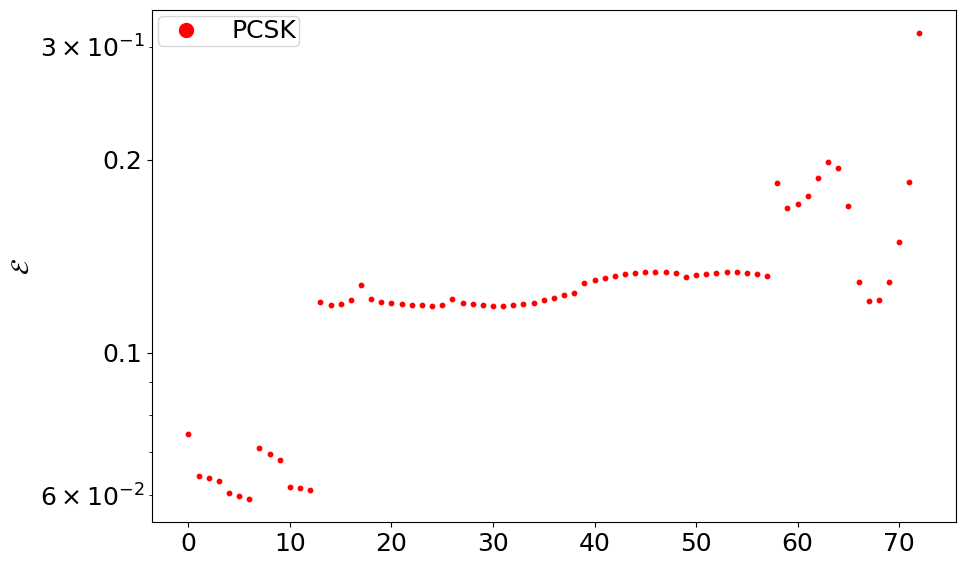

[INFO][_mathtext] Substituting symbol H from STIXNonUnicode


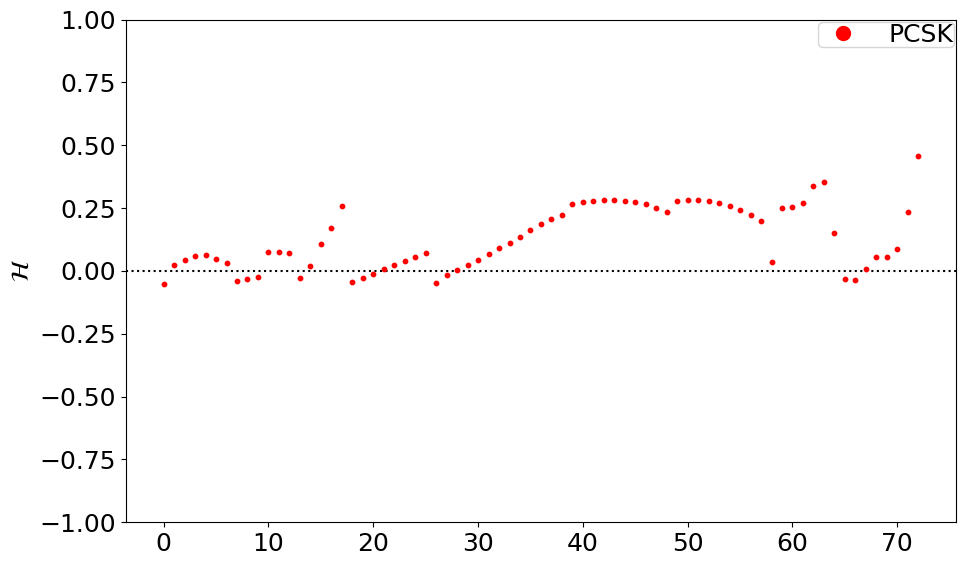

In [14]:
filename_prefix_list = ["JIMWLK_set1","JIMWLK_set2","JIMWLK_set3"]
foldername = 'emulator_test_output_separate_emu'

err1_list = []
hon1_list = []
for file in filename_prefix_list:
    err, hon = read_multiple_emulator_errors_files_BAND([50],foldername,file)
    err1_list.append(err[0])
    hon1_list.append(hon[0])

# combine the sub-lists to one list 
err1_list = [item for sublist in err1_list for item in sublist]
hon1_list = [item for sublist in hon1_list for item in sublist]

colors = ['r','b','g','magenta','teal','orange','purple','grey','seagreen']
labels = ['JIMWLK']

fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.rc('font', size=18)
axs.scatter(range(len(err1_list)), np.abs(err1_list), color=colors[0], marker='o', s=10)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None')
]
axs.legend(handles=legend_elements, loc='upper left', ncols=3, borderpad=0.12, borderaxespad=0.25)
#axs.set_xlim([-1, idx_observable + 1])
axs.set_ylabel(r"$\mathcal{E}$")
axs.set_yscale('log')
axs.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))
axs.yaxis.set_major_locator(ticker.LogLocator(subs=[1.0, 2.0, 5.0]))  # Ensure at least two labels
plt.tight_layout()
plt.savefig("err_full_training_separate_emu.pdf")

# honesty plot
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.rc('font', size=18)
axs.scatter(range(len(hon1_list)), np.log(np.abs(hon1_list)), color=colors[0], marker='o', s=10)

legend_elements = [
    plt.Line2D([0], [0], marker='o', color=colors[0], markersize=10, label='PCSK', linestyle='None')
]
axs.legend(handles=legend_elements, loc='upper right', ncols=3, borderpad=0.02, borderaxespad=0.1)
#axs.set_xlim([-1, idx_observable + 1])
axs.set_ylabel(r"$\mathcal{H}$")
axs.set_ylim([-1, 1])
axs.axhline(y=0, color='k', linestyle=':', zorder=(-10))
plt.tight_layout()
plt.savefig("hon_full_training_separate_emu.pdf")
